In [1]:
%matplotlib widget

# Longitudinal plane and instability simulation

In [13]:
import matplotlib.pyplot as plt
import numpy as np

import xtrack as xt
import xpart as xp
import xwakes as xw

### Import machine and twiss

In [3]:
# Import in Xsuite
env = xt.Environment.from_json('./pimm.json')
env.vars.load_json('./pimm_strengths.json')

line = env.ring
line.configure_bend_model(num_multipole_kicks=5)

tw4d = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/145 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
# Insert aperture limitation to see losses
line.discard_tracker()
line.append_element(name='aperture', element=xt.LimitRect(min_x=-0.05, max_x=0.05))

<Line  at 13804904208>

### Switch on the RF

In [6]:
line.vars['vrf'] = 10e3            # V
line.vars['frf'] = 1 / tw4d.T_rev0 # h=1

In [7]:
# 6D twiss
tw = line.twiss()
tw.qs

0.0013298906722783999

### Inspect longitudinal phase space

In [8]:
# Build a set of particles with different momenta
p = line.build_particles(delta=np.linspace(-1e-2, 1e-2, 41))

In [9]:
# Track
line.track(p, num_turns=2000, turn_by_turn_monitor=True, with_progress=True)

Tracking:   0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
mon = line.record_last_track

Text(0, 0.5, '$\\delta$ [10$^{-3}$]')

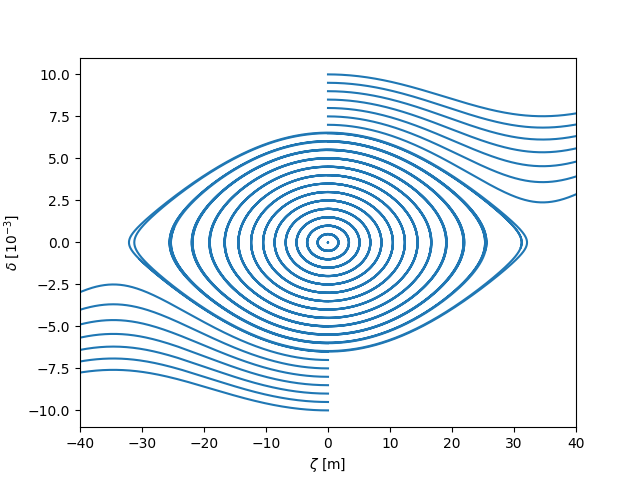

In [11]:
plt.figure()
plt.plot(mon.zeta.T, mon.delta.T*1e3, color='C0');
plt.xlim(-40, 40)
plt.xlabel(r'$\zeta$ [m]')
plt.ylabel(r'$\delta$ [10$^{-3}$]')

## Install transverse wakefields

In [14]:
wf = xw.WakeResonator(kind='dipolar_x',
                      r=100e6, # Shunt impedance [Ohm/m]
                      f_r=1.3e6,
                      q=1.)
wf.configure_for_tracking(zeta_range=(-20, 20), num_slices=20)                      

In [16]:
# Install wakefield in the Xsuite ring
line.append('wf', obj=wf)

### Generate a bunch matched to the bucket and to the optics

In [17]:
%%capture
line.build_tracker()

bunch = xp.generate_matched_gaussian_bunch(line=line,num_particles=1000,
    total_intensity_particles=1e11, nemitt_x=2e-6, nemitt_y=2e-6, sigma_z=10.)
bunch.circumference = tw.circumference # required by PyHEADTAIL

# Initial kick of 1 mm
bunch.x += 1e-3

# Keep initial state
bunch0 = bunch.copy() 

### Simulate 1000 turns

In [19]:
# Define quantities to be logged during tracking
def compute_x_mean(line, particles):
    bunch.hide_lost_particles()
    x_ave = np.mean(particles.x)
    bunch.unhide_lost_particles()
    return x_ave

def compute_intensity(line, particles):
    bunch.hide_lost_particles()
    inten = np.sum(particles.weight)
    bunch.unhide_lost_particles()
    return inten

track_log = xt.Log(x_mean=compute_x_mean, intensity=compute_intensity)

In [20]:
# Track!
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=10)

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


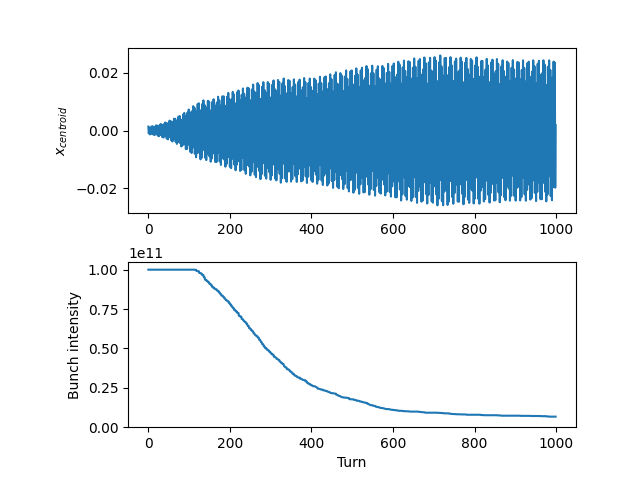

In [21]:
# Plot logged data
x_mean = line.log_last_track['x_mean']
intensity = line.log_last_track['intensity']

plt.figure()
ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$x_{centroid}$')
plt.plot(x_mean)
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(intensity)
plt.ylim(bottom=0)
plt.ylabel('Bunch intensity')
plt.xlabel('Turn')

plt.subplots_adjust(left=0.2, hspace=0.3, top=0.9)

### Adjust the sextupoles to change the chromaticity

In [30]:
%%capture
line.enable_time_dependent_vars = False
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksf', 'ksd'], step=1e-3),
    targets=xt.TargetSet(dqx=-4., dqy=-4., tol=1e-3, tag="chrom")
)
opt.solve()

### Repeat the simulation

In [31]:
bunch = bunch0.copy()

In [32]:
bunch.x += 1e-3
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=10)


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

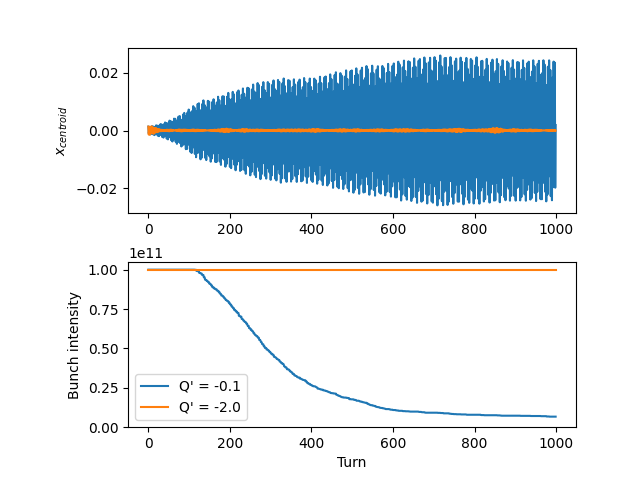

In [33]:
# Plot logged data
x_mean_high_chroma = line.log_last_track['x_mean']
intensity_high_chroma = line.log_last_track['intensity']

plt.figure()
ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$x_{centroid}$')
plt.plot(x_mean, label="Q' = -0.1")
plt.plot(x_mean_high_chroma, label="Q' = -2.0")
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(intensity, label="Q' = -0.1")
plt.plot(intensity_high_chroma, label="Q' = -2.0")
plt.ylim(bottom=0)
plt.ylabel('Bunch intensity')
plt.xlabel('Turn')
plt.legend()

plt.subplots_adjust(left=0.2, hspace=0.3, top=0.9)